In [1]:
# to make import as we would be in root directory
import sys
sys.path.append('..')

In [2]:
import warnings

import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange
import matplotlib.pyplot as plt
import cv2

from lib.autoencoders import SimpleAutoencoder
from lib.clusterizer import EnhancedSpectralClustering
from lib.configs import Config
from lib.data import MAPPINGS
import lib.training as training
import lib.utils as utils

c:\Users\Lukasz\anaconda3\envs\un7\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# hide some warning algorithms
warnings.filterwarnings('ignore')
plt.set_loglevel('warning')

In [4]:
%load_ext autoreload

In [5]:
%autoreload

## Loading training dataset

In [5]:
emnist_pages, kmnist_pages, text_pages = training.load_dataset_pages('small_distortions_1_char', 36)

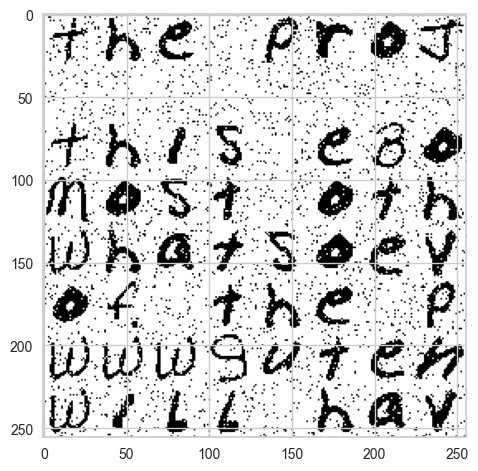

In [6]:
plt.imshow(emnist_pages[0][:256, :256], cmap='gray');

In [7]:
emnist_pages = utils.filter_noise(emnist_pages)
kmnist_pages = utils.filter_noise(kmnist_pages)

100%|██████████| 36/36 [00:01<00:00, 18.20it/s]


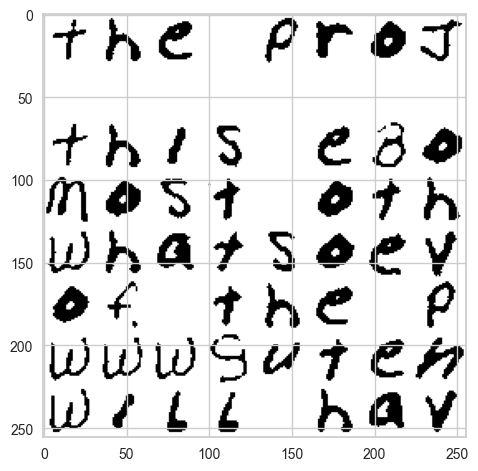

In [8]:
plt.imshow(emnist_pages[0][:256, :256], cmap='gray');

In [9]:
emnist_pages = 1 - emnist_pages
kmnist_pages = 1 - kmnist_pages

In [10]:
emnist_chars = rearrange(emnist_pages, 'p (H h) (W w) -> (p H W) h w', h=32, w=32)
kmnist_chars = rearrange(kmnist_pages, 'p (H h) (W w) -> (p H W) h w', h=32, w=32)
true_labels = np.array([MAPPINGS[chr(c)] for c in text_pages.flatten()])
del emnist_pages, kmnist_pages  # to release some ram

In [11]:
emnist_chars, kmnist_chars, true_labels = training.filter_white_characters(emnist_chars, kmnist_chars, true_labels, threshold=0.1)

Dropped 67.2% characters
Incorrectly removed characters: 1
Whitespaces missed: 0


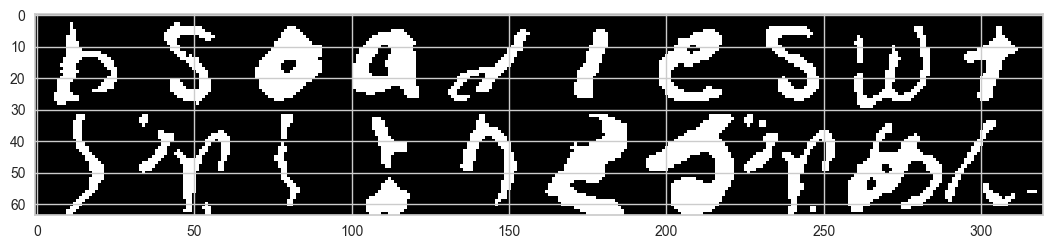

In [12]:
training.show_datasets(emnist_chars, kmnist_chars, samples_count=10)

In [13]:
conf = Config(
    name='small_distortions_1_char',
    emnist_ae=SimpleAutoencoder(output_features=12),
    kmnist_ae=SimpleAutoencoder(output_features=12)
)

econf = conf.emnist
kconf = conf.kmnist

In [14]:
conf.load()

## EMNIST

In [14]:
econf.autoencoder.model.fit(emnist_chars, emnist_chars, epochs=4, batch_size=64);

Epoch 1/4
1682/1682 [==============================] - 18s 9ms/step - loss: 0.0661
Epoch 2/4
1682/1682 [==============================] - 15s 9ms/step - loss: 0.0370
Epoch 3/4
1682/1682 [==============================] - 15s 9ms/step - loss: 0.0326
Epoch 4/4
1682/1682 [==============================] - 15s 9ms/step - loss: 0.0303


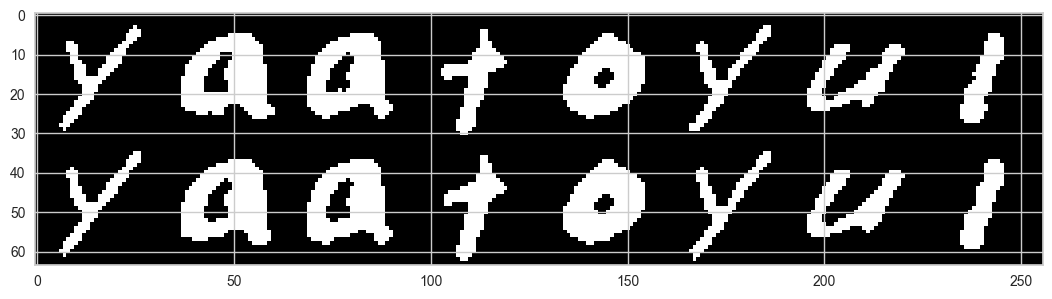

In [15]:
training.test_autoencoder(econf.autoencoder, emnist_chars, samples_count=8, binarize=True)

In [16]:
encoded_emnist = econf.autoencoder.encoder.predict(emnist_chars, batch_size=64)

1682/1682 [==============================] - 2s 1ms/step


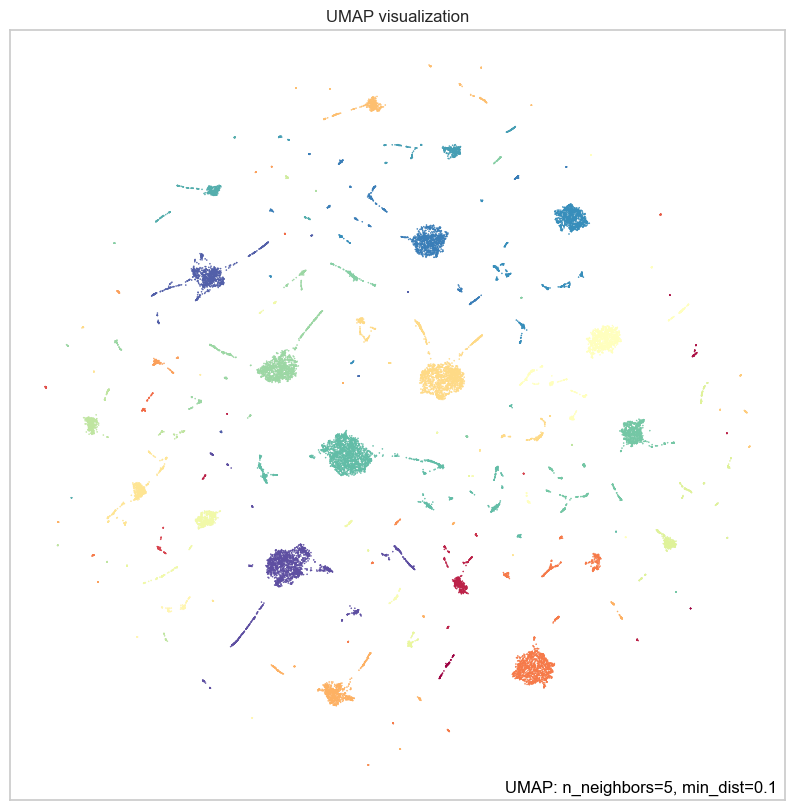

In [36]:
utils.visualize_clusters(encoded_emnist, labels=true_labels, n_samples=25_000)

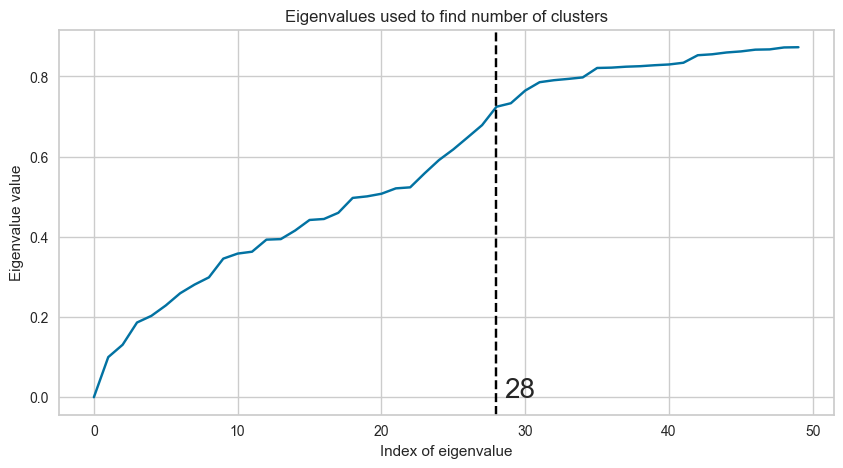

In [17]:
emnist_n_clusters = utils.get_number_of_clusters_with_eigen_values(encoded_emnist, n_samples=10_000)

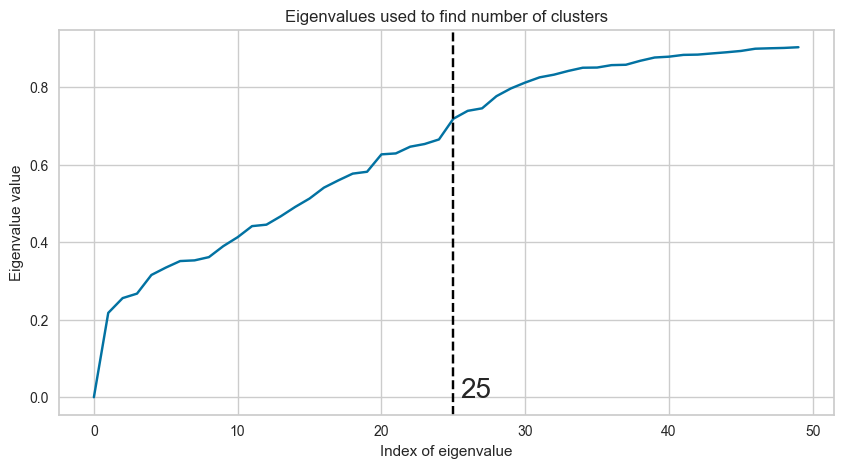

In [ ]:
emnist_n_clusters = utils.get_number_of_clusters_with_eigen_values(encoded_emnist, n_samples=10_000)

In [27]:
econf.clusterizer = EnhancedSpectralClustering(n_clusters=emnist_n_clusters)
econf.clusterizer.fit(utils.sample(encoded_emnist, n=20_000))

In [28]:
emnist_labels = econf.clusterizer.predict(encoded_emnist)
sorted_encoded_emnist = utils.sort_by_labels(encoded_emnist, labels=emnist_labels)
sorted_true_labels = utils.sort_by_labels(true_labels, labels=emnist_labels)

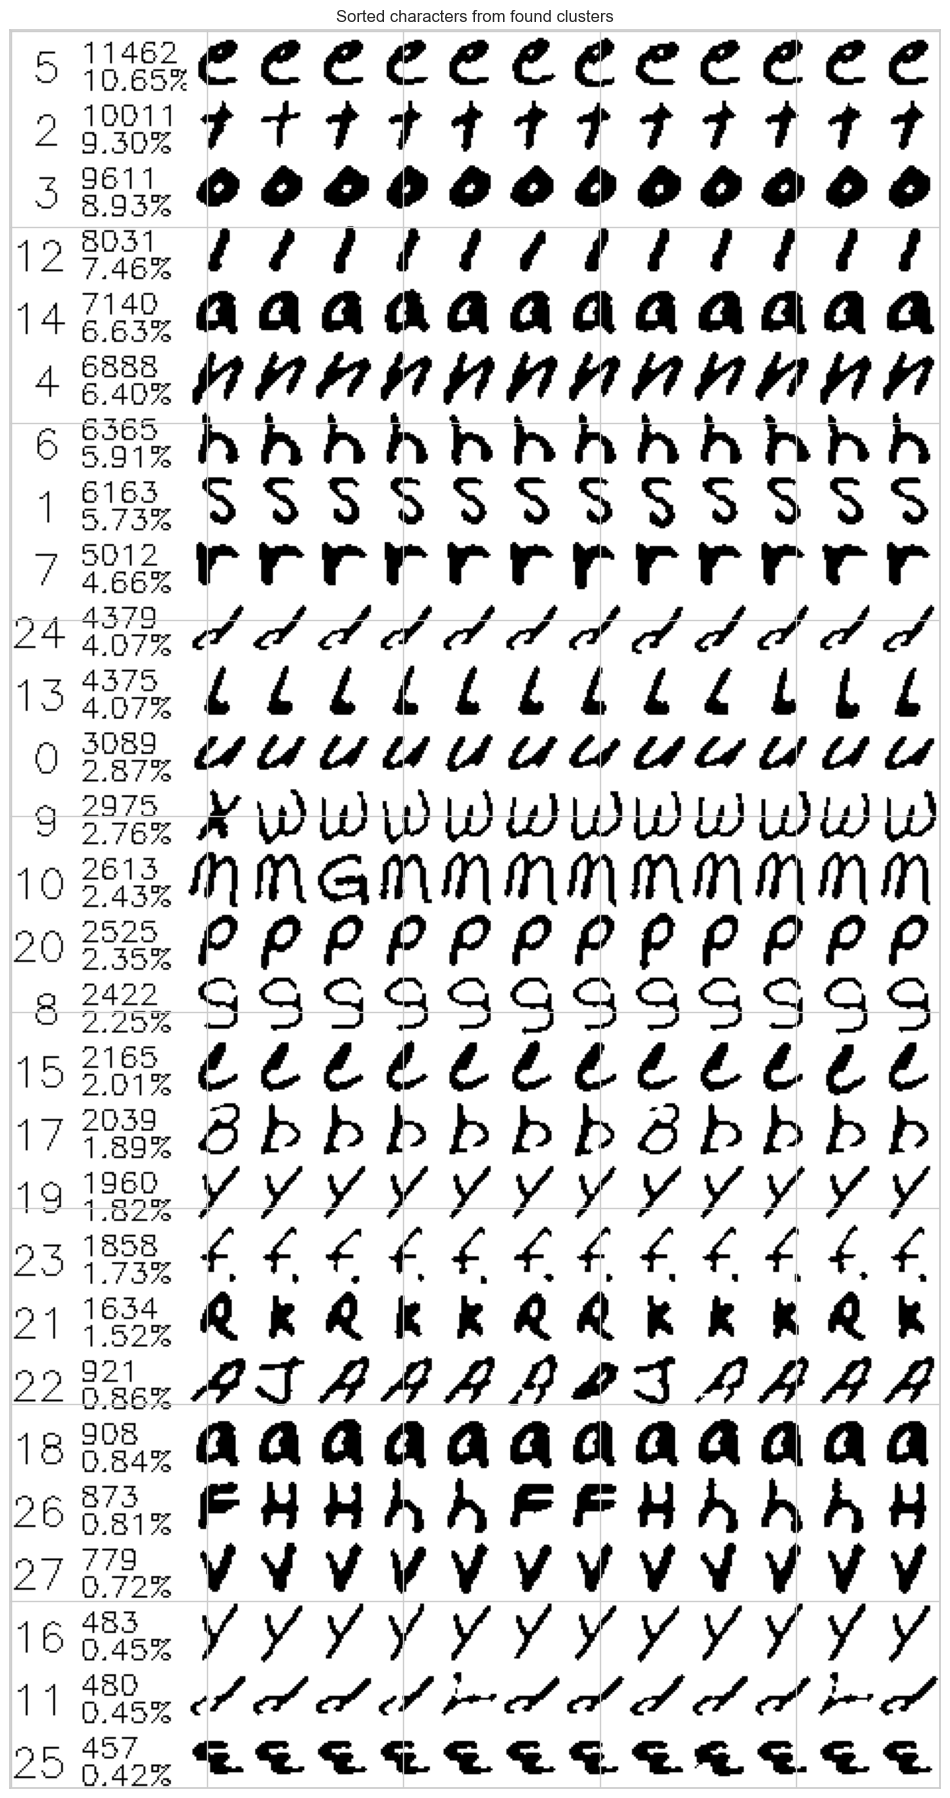

In [20]:
utils.show_sorted_characters(sorted_encoded_emnist, econf.autoencoder, binarize=True);

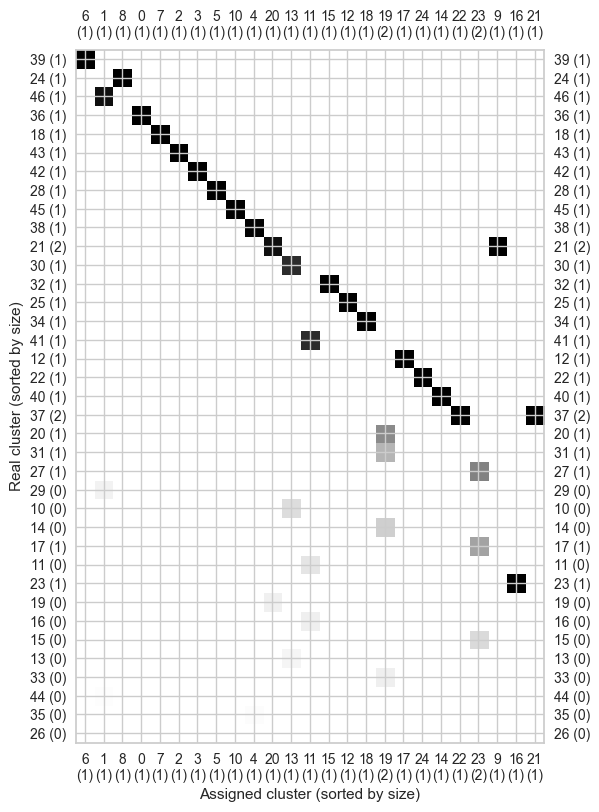

In [ ]:
utils.show_clusters_consistency_matrix(sorted_true_labels);

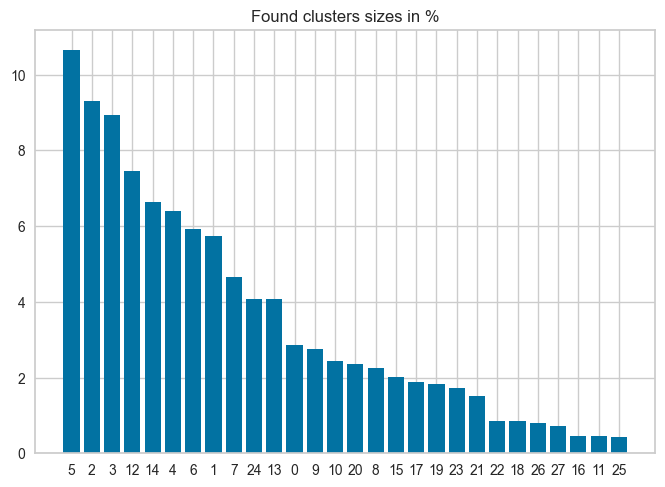

In [23]:
econf.counts = np.array([len(class_characters) for class_characters in sorted_encoded_emnist])
utils.show_sorted_bar_chart(econf.counts / sum(econf.counts) * 100, title='Found clusters sizes in %')

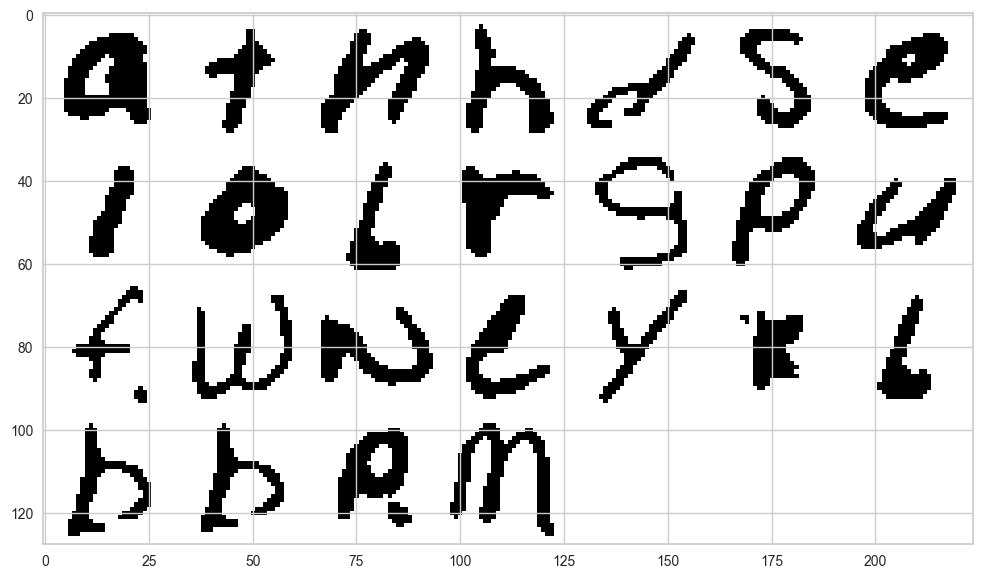

In [45]:
econf.characters = training.create_characters_representatives(sorted_encoded_emnist, econf.autoencoder)
training.show_characters_representatives(econf.characters)

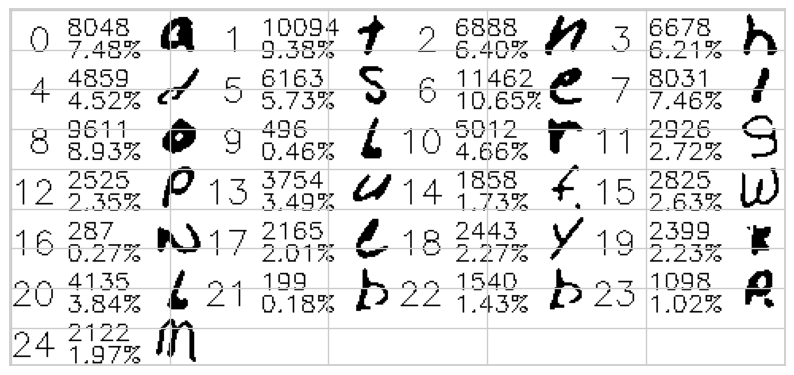

In [46]:
training.show_subconfig_characters(econf);

In [47]:
econf.save()

## KMNIST

In [124]:
kconf.autoencoder.model.fit(kmnist_chars, kmnist_chars, epochs=4, batch_size=64);

Epoch 1/4
1682/1682 [==============================] - 15s 9ms/step - loss: 0.0831
Epoch 2/4
1682/1682 [==============================] - 15s 9ms/step - loss: 0.0504
Epoch 3/4
1682/1682 [==============================] - 15s 9ms/step - loss: 0.0461
Epoch 4/4
1682/1682 [==============================] - 15s 9ms/step - loss: 0.0440


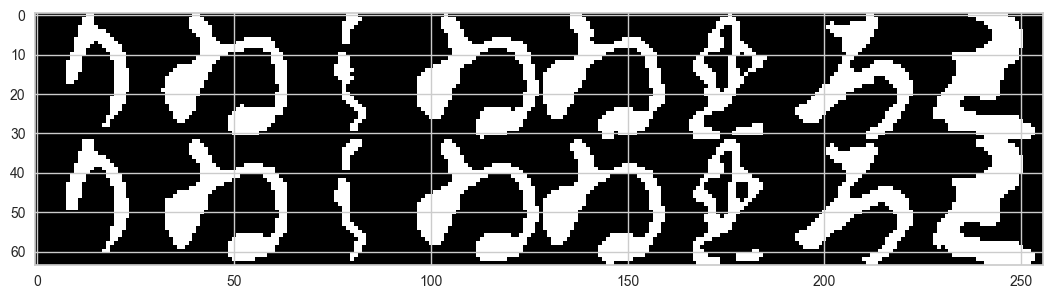

In [15]:
training.test_autoencoder(kconf.autoencoder, kmnist_chars, samples_count=8, binarize=True)

In [16]:
encoded_kmnist = kconf.autoencoder.encoder.predict(kmnist_chars, batch_size=64)

1682/1682 [==============================] - 3s 2ms/step


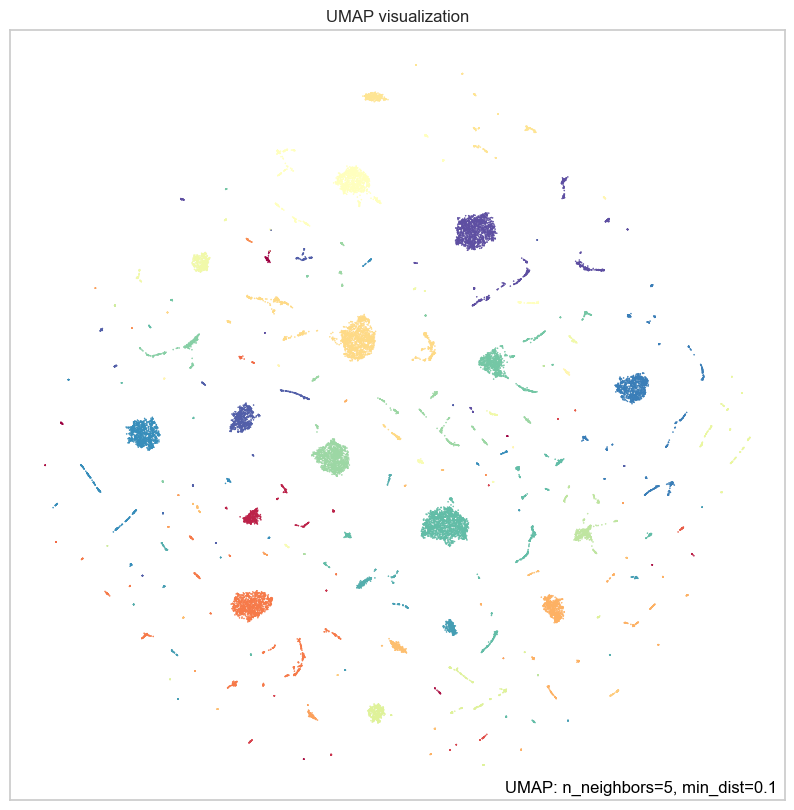

In [104]:
utils.visualize_clusters(encoded_kmnist, labels=true_labels, n_samples=25_000)

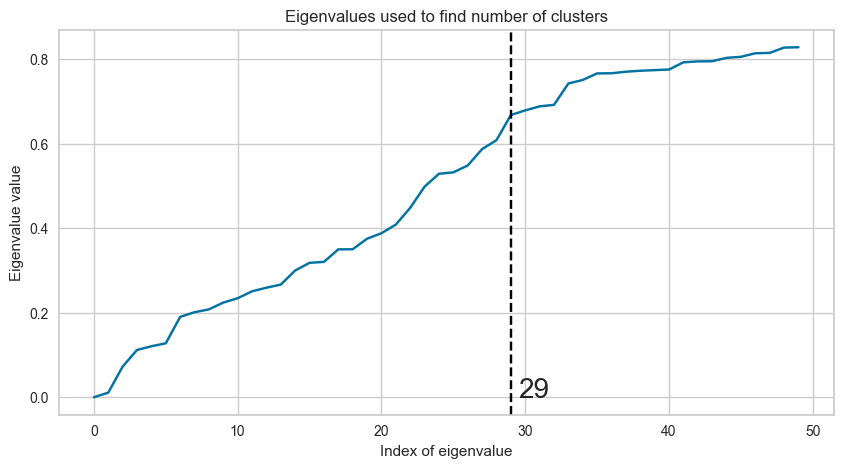

In [105]:
kmnist_n_clusters = utils.get_number_of_clusters_with_eigen_values(encoded_kmnist, n_samples=10_000)

In [ ]:
kconf.clusterizer = EnhancedSpectralClustering(n_clusters=kmnist_n_clusters)
kconf.clusterizer.fit(utils.sample(encoded_kmnist, n=30_000))

In [17]:
kmnist_labels = kconf.clusterizer.predict(encoded_kmnist)
sorted_encoded_kmnist = utils.sort_by_labels(encoded_kmnist, labels=kmnist_labels)
sorted_true_labels = utils.sort_by_labels(true_labels, labels=kmnist_labels)

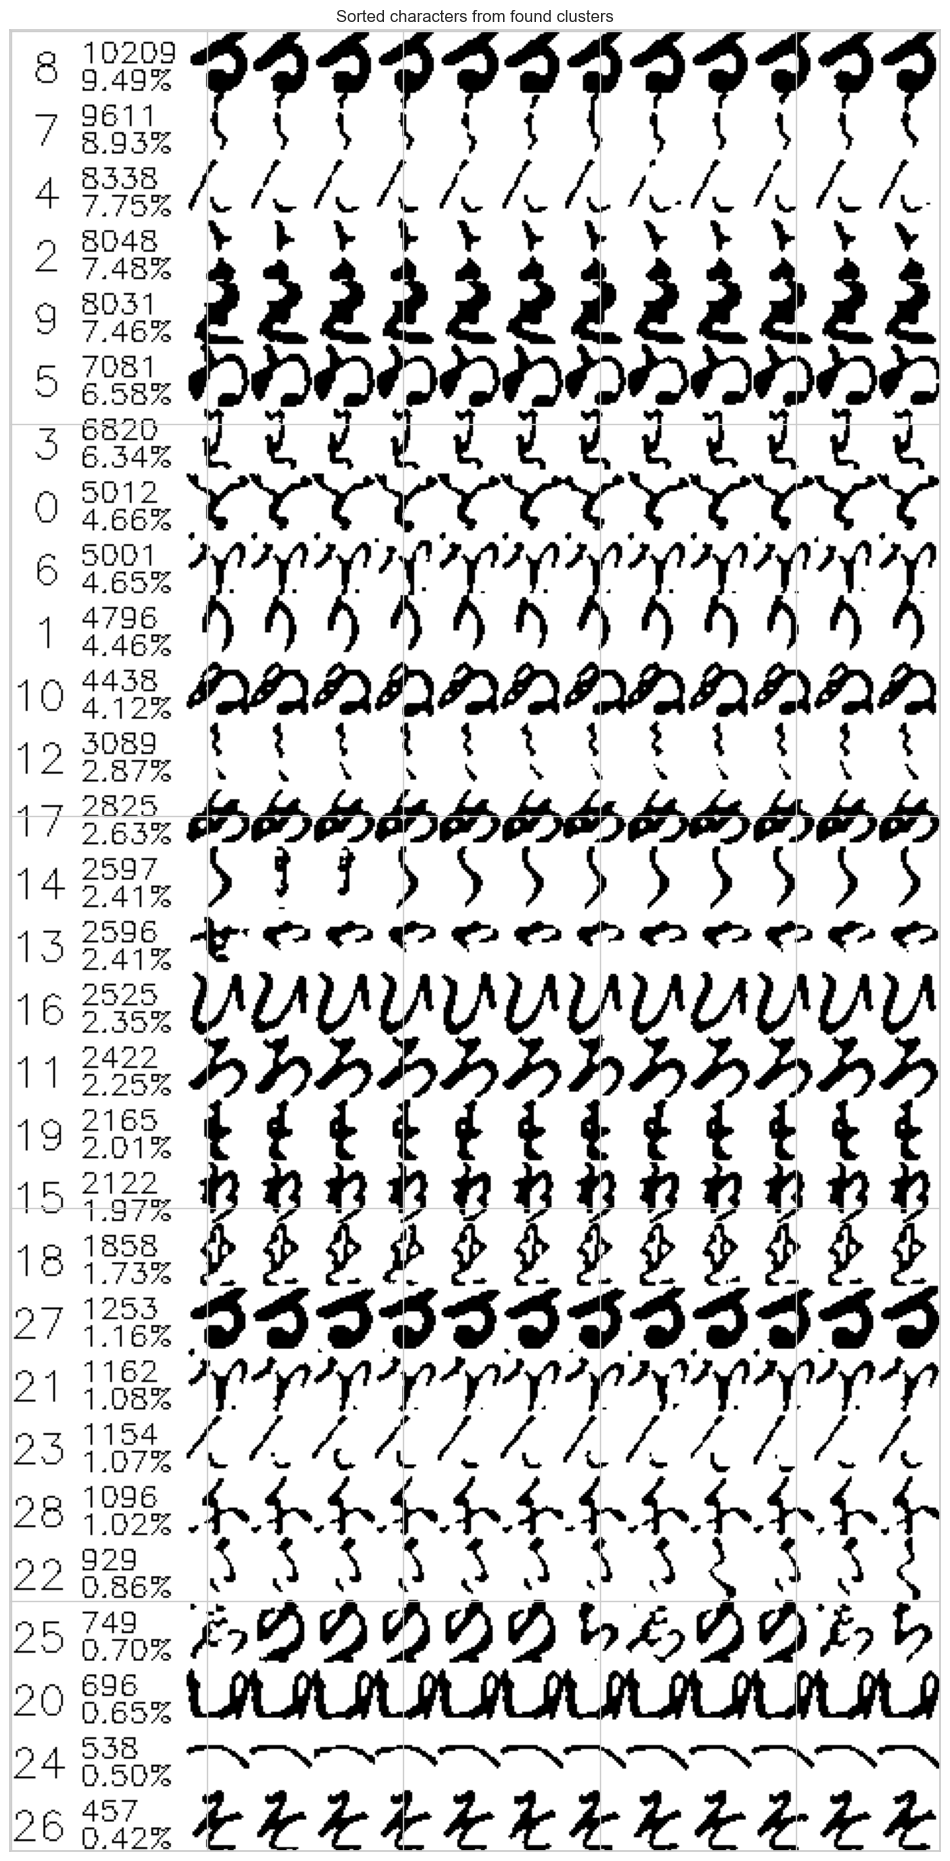

In [19]:
utils.show_sorted_characters(sorted_encoded_kmnist, kconf.autoencoder, binarize=True);

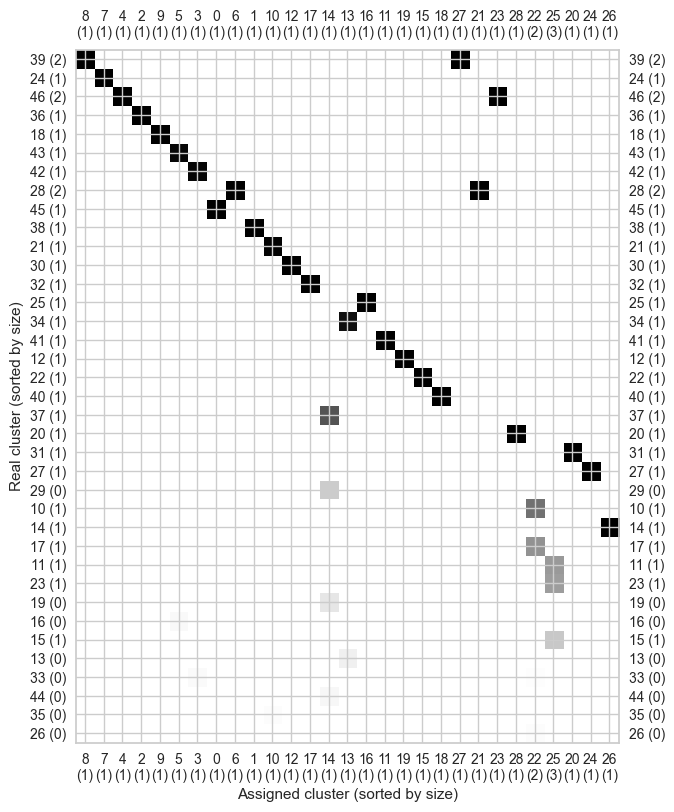

In [20]:
utils.show_clusters_consistency_matrix(sorted_true_labels);

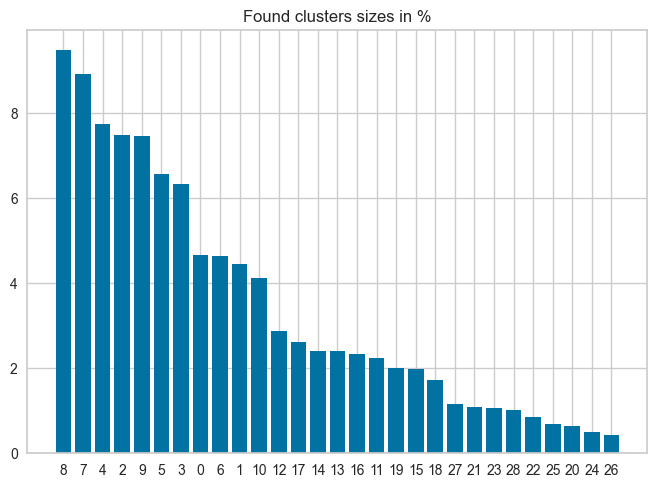

In [23]:
kconf.counts = np.array([len(class_characters) for class_characters in sorted_encoded_kmnist])
utils.show_sorted_bar_chart(kconf.counts / sum(kconf.counts) * 100, title='Found clusters sizes in %')

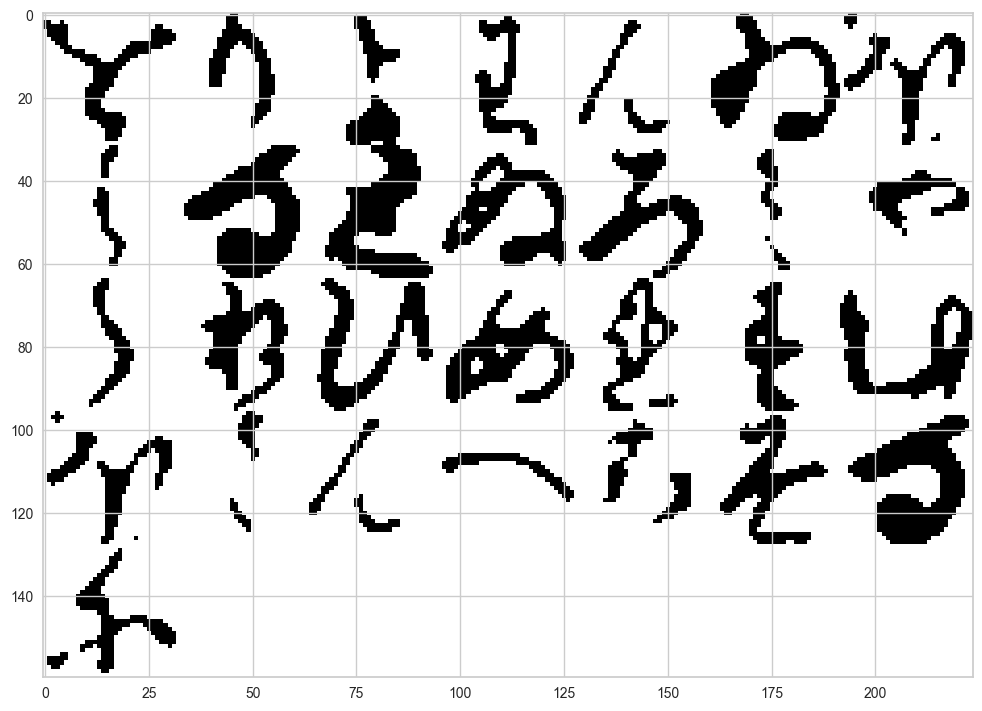

In [24]:
kconf.characters = training.create_characters_representatives(sorted_encoded_kmnist, kconf.autoencoder)
training.show_characters_representatives(kconf.characters)

In [25]:
kconf.save()

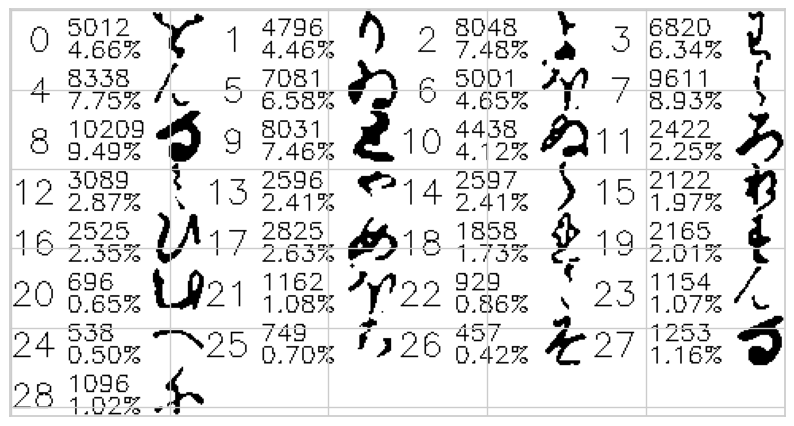

In [26]:
training.show_subconfig_characters(kconf);

## Mapping

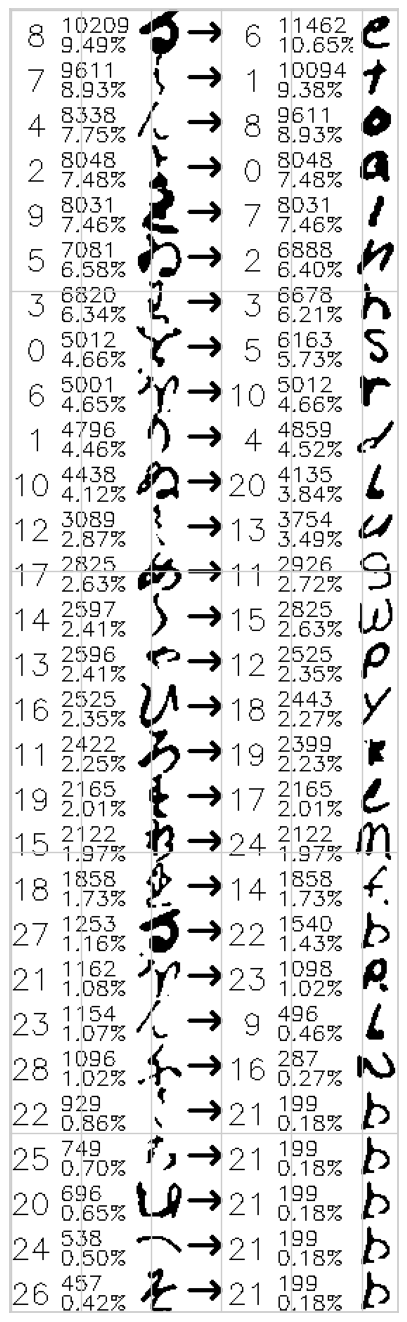

In [27]:
conf.load()
conf.mapping = training.create_mapping(conf.kmnist.counts, conf.emnist.counts)
training.show_mapping(conf)

In [28]:
conf.save_mapping()